# KERAS and TENSORFLOW
TUTORIAL: Using a Multi Layer Perceptron in order to separate hh from TTbar. In example we train several masses h2 masses instead than a single mass point. 
(%lsmagic for magic commanda and ! for bash instruction)

In [1]:
# We start by importing all the necessary packages
import sys;
import os, sys, array, re, math, random, subprocess, glob
from math import *
import numpy as np
import scipy
from numpy.lib.recfunctions import stack_arrays
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cPickle
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import compute_class_weight
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Highway, MaxoutDense, Masking, GRU, Merge, Input, merge
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
import deepdish.io as io
import ROOT
from ROOT import gSystem, gROOT, gApplication, TFile, TTree, TCut, TH1F, TCanvas
from root_numpy import root2array 
from IPython.display import HTML, IFrame
import seaborn as sns; sns.set()
print "I you had no error so far, this is great! We can start the tutorial."

Using Theano backend.


Welcome to JupyROOT 6.08/06
I you had no error so far, this is great! We can start the tutorial.


/Users/Luca2/Library/Python/2.7/lib/python/site-packages/root_numpy/__init__.py:34: RuntimeWarning: ROOT 6.08/06 is currently active but you installed root_numpy against ROOT 6.08/00. Please consider reinstalling root_numpy for this ROOT version.
  RuntimeWarning)
/Users/Luca2/Library/Python/2.7/lib/python/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.12.1 is currently installed but you installed root_numpy against numpy 1.11.0. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


We set some variables we will use later

In [2]:
# Check this file out, it contains many functions we will use.
execfile("Useful_func.py")
# Fix random seed for reproducibility
seed = 7; np.random.seed(seed);
# Input paramters
debug = True #(Verbose output)
folder='Plots_hh_tt_parametric_MLP' # Folder with Plots
MakePlots=True # Set False if you want to run faster
folderCreation  = subprocess.Popen(['mkdir -p ' + folder], stdout=subprocess.PIPE, shell=True); folderCreation.communicate()
folderCreation2 = subprocess.Popen(['mkdir -p models/'], stdout=subprocess.PIPE, shell=True); folderCreation2.communicate()

('', None)

Now We Start manipulating ROOT files into a format we can use to train a MVA

In [13]:
# Our goal is to separate BX Signal from TT background. The machine learning only want to analyze "good events": 
# 1) Applying a preselection to out Signal and background events
my_selec = 'met_pt>20 && met_pt<500 && muon1_pt>20 && fabs(muon1_eta)<2.4 && muon2_pt>10 && fabs(muon2_eta)<2.4 && pt_l1l2<500 && pt_b1b2<500 && mass_l1l2>12 && mass_l1l2<500 && mass_b1b2<500 && b1jet_pt>20 && fabs(b1jet_eta)<2.4 && b2jet_pt>20 && fabs(b2jet_eta)<2.4 && mass_trans>10 && mass_trans<500 && HT<4000'
# 2) Selecting the branches that contains the information we want to use (in general)
my_branches = ["mass_trans","dphi_llmet","dphi_llbb","eta_l1l2","pt_l1l2","mass_l1l2","eta_b1b2","pt_b1b2","mass_b1b2","dR_minbl","dR_l1l2b1b2","HT","met_pt","muon1_pogSF","muon2_pogSF","XsecBr"]
# 3) Selecting the branches that contains the information we want to use (in the training)
my_branches_training = ["mass_trans","dphi_llmet","dphi_llbb","eta_l1l2","pt_l1l2","mass_l1l2","eta_b1b2","pt_b1b2","mass_b1b2","dR_minbl","dR_l1l2b1b2","HT","met_pt"]
    
# Converting Root files in dataframe (Very useful, checnl root2panda in Useful_func.py)
hh1     = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-260_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh2     = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-270_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh3     = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-300_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh4     = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-350_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh5     = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-400_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh6     = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-450_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh7     = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-500_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh8     = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-550_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh9     = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-600_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh10    = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-650_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh11    = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-750_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh12    = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-800_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh13    = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-900_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh14    = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-1000_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
HH_ALL = [hh1,hh2,hh3,hh4,hh5,hh6,hh7,hh8,hh9,hh10,hh11,hh12,hh13,hh14]
sampleName = ['Radion_260','Radion_270','Radion_300','Radion_350','Radion_400','Radion_450','Radion_500','Radion_550','Radion_600','Radion_650','Radion_750','Radion_800','Radion_900','Radion_1000',]
## TT is so heavy that I already saved the final dataframe (and I splitted it if 5 so that each df is smaller than 100 Mb).
TT_df_list = ['files/tt_dataframe_0.csv','files/tt_dataframe_1.csv','files/tt_dataframe_2.csv','files/tt_dataframe_3.csv','files/tt_dataframe_4.csv']
ttbar_df_list = (pd.read_csv(f_df) for f_df in TT_df_list)
ttbar = pd.concat(ttbar_df_list, ignore_index=True)                    
ttbar = ttbar.drop(ttbar.columns[[0, 1]], 1) #Remove 2 extra columns we have in this df, so it match with Signal
# Create a variable that is the total weight (weight=weight for xsec, reweighting=weight depending on muons)
for HH in HH_ALL:
    HH['fin_weight'] = HH['XsecBr'] * HH['muon1_pogSF'] * HH['muon2_pogSF'] #1pb
ttbar['fin_weight']  = ttbar['XsecBr'] * ttbar['muon1_pogSF'] * ttbar['muon2_pogSF'] #87pb
## Alternatively you can save a df as a h5 file (for quick loading in the future)
#  Ex: io.save(open('models/ttbar.h5', 'wb'), ttbar); ttbar = io.load(open('models/ttbar.h5', 'rb'));

if debug:
    print("---> HH_ALL[0] Displayed as panda dataframe: "); print(HH_ALL[0])
    print("The shape for hh is (samples, features): "); print(HH_ALL[0].shape)
    print("The shape for tt is (samples, features): "); print(ttbar.shape)
    print HH_ALL[0].keys()
    print ttbar.keys()


---> HH_ALL[0] Displayed as panda dataframe: 
      mass_trans  dphi_llmet  dphi_llbb  eta_l1l2     pt_l1l2  mass_l1l2  \
0      58.836517    2.036996  -2.195011 -1.761931   53.369804  47.703281   
1      91.472862    1.837220   1.374906 -1.877273   52.681824  24.148767   
2      84.094986    1.812677  -0.262167 -0.938847   66.133118  64.216621   
3     113.967056    2.257362  -1.764214 -0.466149   71.513741  26.362066   
4      62.980377   -1.595165   0.880271  0.067176   39.395412  34.028343   
5      94.639915   -2.998709   2.102583 -0.483183   58.199478  15.722157   
6     127.376617    2.766692  -2.421544 -1.769549   61.554604  13.851027   
7      12.867005   -0.165128  -0.968602  0.159346   59.969578  57.782337   
8     118.501419   -2.763937   0.571166 -0.473403   37.067215  44.826050   
9     103.312714   -2.600723  -2.595056 -1.248913   62.974575  43.908936   
10     49.520870    1.162006   3.122833 -0.601111   65.717010  37.003166   
11     10.860861    0.174303   0.523037 -0

In [17]:
# %matplotlib inline #Too many plots to dispal them here
# Plots of the branches we selected
if MakePlots:
    iH =0
    for HH in HH_ALL:
        for key in ttbar.keys() :
            if(key!="muon1_pogSF" and key!="muon2_pogSF" and key!="XsecBr" and key!="fin_weight") :
                matplotlib.rcParams.update({'font.size': 16})
                fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
                bins = np.linspace(my_max(min(ttbar[key]),0.), max(ttbar[key]), 50)
                _ = plt.hist(HH[key],  bins=bins, histtype='step', normed=True, label=sampleName[iH], linewidth=2)
                _ = plt.hist(ttbar[key], bins=bins, histtype='step', normed=True, label=r'$t\overline{t}$')
                plt.xlabel(key)
                plt.ylabel('Entries')
                plt.legend(loc='best')
                plt.savefig(folder + "/" + str(key) + '_' + str(sampleName[iH]) + '.pdf')
        iH+=1
        

You need:
1. X : matrix with raw=#Events and column=Variables to discriminate."
2. w : A vector containig the weights of each event"
3. Y : A vector containing for each event if it is signal (0) or TT (1)"

In [6]:
print('Now lets start to talk about DNN!')
#You only need a Dataframe for the training. So you merge all the one you have
df =  pd.concat((HH_ALL[0][my_branches_training], HH_ALL[0][my_branches_training], HH_ALL[0][my_branches_training], HH_ALL[0][my_branches_training], HH_ALL[0][my_branches_training], HH_ALL[0][my_branches_training], HH_ALL[0][my_branches_training], HH_ALL[0][my_branches_training], HH_ALL[0][my_branches_training], HH_ALL[0][my_branches_training], ttbar[my_branches_training]), ignore_index=True)
# Turn the df the desired ndarray "X" that can be directly used for ML applications.
X = df.as_matrix() # Each row is an object to classify, each column corresponds to a specific variable.
# Take the weights
w =  pd.concat((hh['fin_weight'], ttbar['fin_weight']), ignore_index=True).values
# This is the array with the true values: 0 is signal, 1 if TT.
y = []
for _df, ID in [(hh, 0), (ttbar, 1)]:
    y.extend([ID] * _df.shape[0])
y = np.array(y)

# Randomly shuffle and automatically split all your objects into train and test subsets
ix = range(X.shape[0]) # array of indices, just to keep track of them for safety reasons and future checks
X_train, X_test, y_train, y_test, w_train, w_test, ix_train, ix_test = train_test_split(X, y, w, ix, train_size=0.7) # Train here is 70% of the total statistic
# It is common practice to scale the inputs to Neural Nets such that they have approximately similar ranges (it atually improve the results)
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) # You are applying the same transformation done to X_train, to X_test.

Now lets start to talk about DNN!


In [7]:
# This takes a while, but it is worth do do it once. It shows the correlations for S and B overimposed.
# More variables you add in var_toPlot, more times it takes.
if MakePlots:
    # Next lines to select the same number of entries
    rawS = hh.shape[0]
    rawB = ttbar.shape[0]
    Nraw = rawS;
    if (rawB<rawS): Nraw = rawB;
    hh_plot    = hh.iloc[0:Nraw]
    ttbar_plot = ttbar.iloc[0:Nraw]
    # Add the target, that is missing in hh and ttbar
    hh_plot['Target'] = 0
    ttbar_plot['Target'] = 1
    var_toPlot=["Target","dphi_llmet","pt_l1l2","mass_l1l2","pt_b1b2","mass_b1b2","HT","met_pt"]
    #var_toPlot = ["Target","mass_b1b2","mass_l1l2"]
    df_withY = pd.concat((hh_plot[var_toPlot], ttbar_plot[var_toPlot]), ignore_index=True)
    # You can select the variable to plot in sns.pairplot using an argumnet vars=['var1','var2'...]
    sns_plot = sns.pairplot(df_withY, hue='Target',palette=["#e74c3c","#9b59b6"],plot_kws={"s": 3,"alpha":0.3},size=5)
    sns_plot.savefig(folder + "/Variables_pairplot.png")

In [8]:
# Multilayer Perceptron (MLP) definition
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu')) # Linear transformation of the input vector. The first number is output_dim.
model.add(Dropout(0.1)) # To avoid overfitting. It masks the outputs of the previous layer such that some of them will randomly become inactive and will not contribute to information propagation.
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(10,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax')) # Last layer has to have the same dimensionality as the number of classes we want to predict, here 2.
model.summary()
# Now you need to declare what loss function and optimizer to use (and compile your model).
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                140       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
__________

In [9]:
print('---------------------------Training:---------------------------')
try:
    history = model.fit(X_train, y_train, batch_size=50, epochs=100, verbose=1,
              callbacks = [
                  EarlyStopping(verbose=True, patience=6, monitor='val_loss'),
                  ModelCheckpoint('models/tutorial-progress.h5', monitor='val_loss', verbose=1, save_best_only=True)
              ],
              validation_split=0.2, validation_data=None, shuffle=True,
              class_weight={
                0 : compute_class_weight("balanced", [0, 1], y)[0], # Function that return "[1/N_classes * ((float(len(y)) / (y == 0).sum())), 1/N_classes * ((float(len(y)) / (y == 1).sum()))]"
                1 : compute_class_weight("balanced", [0, 1], y)[1]
              },
              sample_weight=None,initial_epoch=0)
    
except KeyboardInterrupt:
    print 'Training ended early.'

---------------------------Training:---------------------------
Train on 1063516 samples, validate on 265879 samples
Epoch 1/100
1063516/1063516 [==============================] - 26s - loss: 0.2155 - acc: 0.9060 - val_loss: 0.1551 - val_acc: 0.9417
Epoch 2/100
1063516/1063516 [==============================] - 26s - loss: 0.1605 - acc: 0.9346 - val_loss: 0.1424 - val_acc: 0.9391
Epoch 3/100
1063516/1063516 [==============================] - 25s - loss: 0.1471 - acc: 0.9415 - val_loss: 0.1379 - val_acc: 0.9285
Epoch 4/100
1063516/1063516 [==============================] - 25s - loss: 0.1406 - acc: 0.9451 - val_loss: 0.1374 - val_acc: 0.9408
Epoch 5/100
1063516/1063516 [==============================] - 26s - loss: 0.1376 - acc: 0.9482 - val_loss: 0.1451 - val_acc: 0.9599
Epoch 6/100
1063516/1063516 [==============================] - 25s - loss: 0.1353 - acc: 0.9470 - val_loss: 0.1372 - val_acc: 0.9568
Epoch 7/100
1063516/1063516 [==============================] - 26s - loss: 0.1322 - a

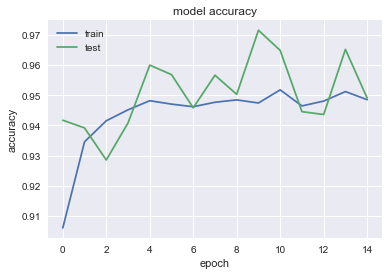

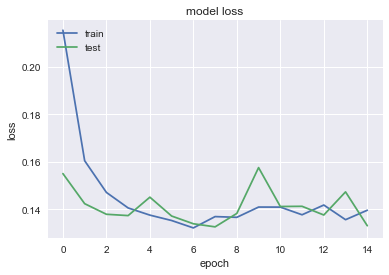

All data in hisotry are:  ['acc', 'loss', 'val_acc', 'val_loss']


In [10]:
# Let's make some plots about the convergence of our model. You can check if:
#  1. It’s speed of convergence over epochs (slope).
#  2. Whether the model may have already converged (plateau of the line).
#  3. Whether the mode may be over-learning the training data (inflection for validation line).

if debug:
    print "All data in hisotry are: ",history.history.keys()
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(folder + '/Check_accuracy.pdf')
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(folder + '/Check_loss.pdf')

In [11]:
# Load the best network (by default you return the last one, you if you save every time you have a better one you are fine loading it later)
model.load_weights('./models/tutorial-progress.h5')
print 'Saving weights...'
model.save_weights('./models/tutorial.h5', overwrite=True)
json_string = model.to_json()
open('./models/tutorial.json', 'w').write(json_string)
print 'Testing...'
yhat = model.predict(X_test, verbose = True, batch_size = 50) # Return a vector of 2 indeces [probToBe_S,probToBe_B]
#Turn them into classes
yhat_cls = np.argmax(yhat, axis=1) # Transform [probToBe_S,probToBe_B] in a vector of 0 and 1 depending if probToBe_S>probToBe_B. Practically return the index of the biggest element (0 is is probToBe_S, if is probToBe_B)
# This should Normalized to the Xsec?
if MakePlots:
    bins = np.linspace(-0.5,1.5,3)
    names = ['','','','hh','','','','tt']
    fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
    ax = plt.subplot()
    ax.set_xticklabels(names, rotation=45)
    _ = plt.hist(yhat_cls, bins=bins, histtype='stepfilled', alpha=0.5, label='prediction',log=True)#, weights=w_test)
    _ = plt.hist(y_test, bins=bins, histtype='stepfilled', alpha=0.5, label='truth',log=True)#, weights=w_test)
    plt.legend(loc='upper right')
    print('Saving:',folder + '/Performance.pdf')
    plt.savefig(folder + '/Performance.pdf')

Saving weights...
Testing...
567450/569742 [============================>.] - ETA: 0s

In [12]:
# With "(y_test != 0) & (yhat_cls == 0)" you get an arrate of bool: [False False False ..., False False False]
print 'Signal efficiency:',     w_test[(y_test == 0) & (yhat_cls == 0)].sum() / w_test[y_test == 0].sum()
print 'Background efficiency:', w_test[(y_test != 0) & (yhat_cls == 0)].sum() / w_test[y_test != 0].sum()
w_1 = np.ones(len(y_test))
print 'Signal efficiency (not weighted):',     w_1[(y_test == 0) & (yhat_cls == 0)].sum() / w_1[y_test == 0].sum()
print 'Background efficiency (not weighted):', w_1[(y_test != 0) & (yhat_cls == 0)].sum() / w_1[y_test != 0].sum()
print "Let's compare with the training samples:"
w_1 = np.ones(len(y_train))
yhat_tr = model.predict(X_train, verbose = True, batch_size = 50)
yhat_trcls = np.argmax(yhat_tr, axis=1)
print ''; print 'Signal efficiency (not weighted) for training:',     w_1[(y_train == 0) & (yhat_trcls == 0)].sum() / w_1[y_train == 0].sum()
print 'Background efficiency (not weighted) for training:', w_1[(y_train != 0) & (yhat_trcls == 0)].sum() / w_1[y_train != 0].sum()

Signal efficiency: 0.940404721071
Background efficiency: 0.043052672127
Signal efficiency (not weighted): 0.940547476476
Background efficiency (not weighted): 0.0429059365108
Let's compare with the training samples:
1323750/1329395 [============================>.] - ETA: 0s
Signal efficiency (not weighted) for training: 0.954688950789
Background efficiency (not weighted) for training: 0.0427481665546


Signal efficiency: 0.949929225605
Background efficiency: 0.0542005451175
Signal efficiency (not weighted): 0.9499572284
Background efficiency (not weighted): 0.0540373349501
Let's compare with the training samples:
1324550/1329395 [============================>.] - ETA: 0ss 
Signal efficiency (not weighted) for training: 0.962116991643
Background efficiency (not weighted) for training: 0.0539014055785